In [49]:
import torch

from pathlib import Path

from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed

from modular_transformers.models.gpt2.configuration_gpt2 import GPT2Config
from modular_transformers.models import components

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.linalg import orth
import pandas as pd

from sklearn.decomposition import PCA

from tqdm import tqdm

#set seeds
torch.manual_seed(0)
np.random.seed(0)
set_seed(0)

#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#set tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [2]:
def load_data(num_bigrams):
    bigram_text = open("bigrams.txt", "r").read().split("\n")
    bigrams = [(int(b[b.find('\t')+1:]), b[:b.find('\t')]) for b in bigram_text if len(b) > 0]
    bigrams.sort(key=lambda x: x[0], reverse=True)
    bigrams = bigrams[:num_bigrams]

    bigram_tokens = [tokenizer.encode(b[1]) for b in bigrams]
    # bigram_tokens = [b + [tokenizer.pad_token_id]*(max_token_num-len(b)) for b in bigram_tokens]
    bigram_tokens = [torch.tensor(b) for b in bigram_tokens]
    # bigram_tokens = torch.cat(bigram_tokens, dim=0)
    return bigram_tokens


In [3]:
#tiny model
# bottleneck_dim = 4
# n_layer = 12

# config = {'vocab_size': len(tokenizer), 'n_ctx': 1024, 'bos_token_id': tokenizer.bos_token_id,
#                     'eos_token_id': tokenizer.eos_token_id, "bottleneck": bottleneck_dim, "n_layer": n_layer}
# config = GPT2Config(config)
# config.n_embds = [768, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
# orig_model = components.LM(config)
# orig_model.to(device)

In [4]:
#small model
# save_dir = Path(f'/om2/user/jackking/MyData/mt/miniberta_100M/768-768-768/reg_loss/checkpoint_216000')
# orig_model = components.LM.from_pretrained(save_dir)
# moorig_modeldel.to(device)

In [5]:
#big model
def load_model(model_path = "gpt2"):
    if model_path == "gpt2":
        orig_model = GPT2LMHeadModel.from_pretrained("gpt2")
    else:
        orig_model = components.LM.from_pretrained(model_path)
    return orig_model.to(device)

In [6]:
class Activations():
    def __init__(self, num_layers, max_token_num):
        self.activations = [[[] for _ in range(num_layers)] for _ in range(max_token_num)]
    
    def register_monitoring_hooks(self, model, max_token_num):
        def hook_wrapper(layer):
            def hook_function(module, input, output):
                for i in range(min(max_token_num, output.shape[1])):
                    self.activations[i][layer].append(output[:, i, :].detach().cpu())
            return hook_function

        for i, layer in enumerate(model.transformer.h):
            layer.mlp.c_proj.register_forward_hook(hook_wrapper(i))

def make_activation_matrix(activations, max_token_num, num_layers):
    final = [[[] for _ in range(num_layers)] for _ in range(max_token_num)]
    for token_num, acts in enumerate(activations):
        if len(acts[0]) < 2:
            final = final[:token_num]
            max_token_num = token_num
            break
        for layer, layer_acts in enumerate(acts):
            matrix = torch.stack(layer_acts, dim=0).squeeze()
            final[token_num][layer] = matrix
    return final, max_token_num

def get_activation_matrix(model, bigram_tokens, max_token_num, num_layers):
    """
    :param model: model to get activations from
    :param bigram_tokens: list of bigram tokens
    :param max_token_num: max number of tokens in bigrams
    :param num_layers: number of layers in model
    :return: activation matrix: token_num: layer: activations (num_bigrams x hidden_size)
    """
    activation_class = Activations(num_layers, max_token_num)
    activation_class.register_monitoring_hooks(model, max_token_num)

    logits = []
    for bigram in tqdm(bigram_tokens):
        input = bigram.to(device)
        output = model(input)
        input.detach()
        logits.append(output.logits[-1, :])
    logits = torch.stack(logits, dim=0)
    activations = activation_class.activations

    activations, max_token_num = make_activation_matrix(activations, max_token_num, num_layers)

    return activations, max_token_num, logits

### Find principal axes to perturb along

In [9]:
def get_pcas(activations, num_layers, max_token_num):
    pcas = [[None for _ in range(num_layers)] for _ in range(max_token_num)]
    for token_num, acts in enumerate(activations):
        for layer, matrix in enumerate(acts):
            pca = PCA()
            if not isinstance(matrix, list):
                matrix = matrix.detach().cpu().numpy()
            else:
                matrix = np.array(matrix).reshape(1, -1)
            pca.fit(matrix)
            pcas[token_num][layer] = pca
    return pcas

In [10]:
#visualize
def plot_pca(token_num, activations, pcas):
    ax, fig = plt.subplots(figsize=(16, 13), nrows=4, ncols=6)
    for layer, pca in enumerate(pcas):

        data = pca.transform(activations[token_num][layer].detach().cpu().numpy())
        variance = pca.explained_variance_ratio_

        #visualize components
        fig[(layer*2)//6, (layer*2)%6].scatter(data[:, 0], data[:, 1])
        fig[(layer*2)//6, (layer*2)%6].set_title(f'Layer {layer}')

        #visualize variance with cumulative sum
        fig[(layer*2)//6, (layer*2)%6 + 1].plot(range(len(variance)), variance.cumsum())
        fig[(layer*2)//6, (layer*2)%6 + 1].set_ylim(0, 1)
        fig[(layer*2)//6, (layer*2)%6 + 1].set_title(f'Layer {layer}')

    plt.show()

In [11]:
def plot_pcas(pcas, activations):
    for token_num, pca in enumerate(pcas):
        print(f'Token {token_num}')
        plot_pca(token_num, activations, pca)

In [12]:
#find the number of components needed to explain a baseline variance as well as a universal cutoff
def get_num_components(orig_pcas, max_token_num, pca_dim, num_layers):
    num_components = [[{} for _ in range(num_layers)] for _ in range(max_token_num)]
    for token_num, layers_pcas in enumerate(orig_pcas):
        for layer, pca in enumerate(layers_pcas):
            variance = pca.explained_variance_ratio_
            for i, v in enumerate(variance.cumsum()):
                if v > 0.8:
                    num_components[token_num][layer]["explained_cutoff"] = i
                    break
            if len(variance) < pca_dim:
                num_components[token_num][layer]["cutoff"] = len(variance)
            else:
                num_components[token_num][layer]["cutoff"] = pca_dim
                
    return num_components

### Perturb along principal axes

In [13]:
def get_orthogonal_vector(v):
    if np.all(v == 0):
        raise ValueError("The input vector cannot be the zero vector.")

    # Create a matrix with the input vector as the first row
    # and fill the rest with random values
    A = np.vstack([v, np.random.rand(len(v)-1, len(v))])

    # Use the null space to find a vector orthogonal to the input vector
    u = np.linalg.svd(A)[2][-1]

    return u

In [14]:
def register_pertubation_hooks(model, orig_pcas, num_components, pertubation_func, max_token_num, pertubation_layers):
    def hook_wrapper(pcs):
        def prehook(module, input):
            for i in range(min(max_token_num, input[0].shape[1], len(pcs))):
                pc_info = pcs[i]
                pc = pc_info[0]
                orthog_pc = pc_info[1]
                detached_input = input[0][:, i, :].detach().cpu().numpy()
                pertubation = pertubation_func(pc, detached_input, orthog_pc).to(device)
                input[0][:, i, :] += pertubation
                pertubation.detach_()
            return input
        return prehook

    #shuffle for different indexing
    reshuffled_pcas = {layer: {} for layer in pertubation_layers}
    for token_num, layers_pcas in enumerate(orig_pcas):
        for layer, pca in enumerate(layers_pcas):
            if layer in pertubation_layers:
                reshuffled_pcas[layer][token_num] = pca
    
    for layer, layer_pcas in reshuffled_pcas.items():
        pcs = []
        #for ever token num in the layer, find the average of the top num_components components
        for token_num, pca in layer_pcas.items():
            nc = num_components[token_num][layer]["cutoff"]
            pc = pca.components_[:nc, :]
            pc = pc.sum(axis=0) / nc
            pc = pc / np.linalg.norm(pc)
            orthog = get_orthogonal_vector(pc)
            pcs.append((pc, orthog))
        model.transformer.h[layer].mlp.dropout.register_forward_pre_hook(hook_wrapper(pcs))


In [70]:
#visualize
def plot_pca_sidebyside(token_num, orig_pcas, perturbed_pcas, orig_activations, perturbed_activations):
    ax, fig = plt.subplots(figsize=(16, 13), nrows=4, ncols=6)
    for layer, (orig_pca, perturbed_pca) in enumerate(zip(orig_pcas, perturbed_pcas)):

        orig_data = orig_pca.transform(orig_activations[token_num][layer].detach().cpu().numpy())
        perturbed_data = perturbed_pca.transform(perturbed_activations[token_num][layer].detach().cpu().numpy())

        #visualize orig components
        fig[(layer*2)//6, (layer*2)%6].scatter(orig_data[:, 0], orig_data[:, 1])
        fig[(layer*2)//6, (layer*2)%6].set_title(f'Original Layer {layer}')

        #visualize perturbed components
        fig[(layer*2)//6, (layer*2)%6 + 1].scatter(perturbed_data[:, 0], perturbed_data[:, 1])
        fig[(layer*2)//6, (layer*2)%6 + 1].set_title(f'Perturbed Layer {layer}')

    plt.show()

In [71]:
#visualize perturbed activations next to original activations
def plot_pca_sidebyside_wrapper(orig_pcas, perturbed_pcas, orig_activations, perturbed_activations):
    for i in range(len(orig_pcas)):
        print(f'Token {i}')
        plot_pca_sidebyside(i, orig_pcas[i], perturbed_pcas[i], orig_activations, perturbed_activations)

In [192]:
def sample_outputs(models, token_selection, bigram_tokens):
    random_bigram_selection = [bigram_tokens[i] for i in token_selection]
    for bigram in random_bigram_selection:
        for model in models:
            input = bigram.to(device)
            output = model(input)
            prediction = output.logits[-1, :].argmax(dim=-1)
            tokenized = tokenizer.decode(prediction)
            print(tokenizer.decode(bigram.squeeze()) + "->" + tokenized)

In [92]:
#ORIG ------------------------------------

def orig(model_path, bigram_tokens, max_token_num):

    orig_model = load_model(model_path)
    num_layers = len(orig_model.transformer.h)

    orig_activations, max_token_num, logits = get_activation_matrix(orig_model, bigram_tokens, max_token_num, num_layers)
    # torch.save(orig_activations, 'test_activations.pt')

    # orig_activations = torch.load('test_activations.pt')
    orig_pcas = get_pcas(orig_activations, num_layers, max_token_num)

    # plot_pcas(orig_pcas, orig_activations)

    return orig_model, orig_pcas, orig_activations, max_token_num, num_layers

In [93]:
#PERTURBATION ------------------------------------

def perturb(model_path, orig_model, orig_pcas, bigram_tokens, max_token_num, pertubation_func, pca_dim, num_layers, pertubation_layers):
    num_components = get_num_components(orig_pcas, max_token_num, pca_dim, num_layers)

    perturbed_model = load_model(model_path)
    num_layers = len(perturbed_model.transformer.h)

    register_pertubation_hooks(perturbed_model, orig_pcas, num_components, pertubation_func, max_token_num, pertubation_layers)
    perturbed_activations, max_token_num, logits = get_activation_matrix(perturbed_model, bigram_tokens, max_token_num, num_layers)
    # torch.save(perturbed_activations, 'gpt2_perturbed_activations.pt')

    # perturbed_activations = torch.load('gpt2_perturbed_activations.pt')
    perturbed_pcas = get_pcas(perturbed_activations, num_layers, max_token_num)

    # plot_pcas(perturbed_pcas, perturbed_activations)

    # plot_pca_sidebyside_wrapper(orig_pcas, perturbed_pcas, orig_activations, perturbed_activations)

    return perturbed_model

In [94]:
num_bigrams = 1000
bigram_tokens = load_data(num_bigrams)
model_path = 'gpt2'
max_token_num = max([len(b) for b in bigram_tokens])

orig_model, orig_pcas, orig_activations, max_token_num, num_layers = orig(model_path, bigram_tokens, max_token_num)

100%|██████████| 1000/1000 [00:11<00:00, 90.27it/s]


In [ ]:
model_path = 'gpt2'
pca_dim = 2
# pertubation_func = lambda x: -torch.tensor(x * np.random.normal(loc=1, scale = 0.1))
#10 * torch.tensor(find_orthogonal_vector_nD(pc))
pertubation_func = lambda pc, input: torch.normal(mean=0, std=100, size=pc.shape)
pertubation_layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

perturbed_model = perturb(model_path, orig_model, orig_pcas, bigram_tokens, max_token_num, pertubation_func, pca_dim, num_layers, pertubation_layers)

In [15]:
def complete_bigrams(model, bigrams):
    completions = []
    for bigram in bigrams:
        input = torch.tensor(tokenizer.encode(bigram)).to(device)
        output = model(input)
        prediction = output.logits[-1, :].argmax(dim=-1)
        tokenized = tokenizer.decode(prediction)
        completions.append(tokenized)
    return completions

In [ ]:
#code for running perturbations on every layer at a time and collecting those activations
import inspect

bigram_results_df = pd.read_csv('bigram_results.csv', index_col=0)
test_bigrams = bigram_results_df['bigram'].tolist()
model_df = pd.read_csv('model_df.csv', index_col=0)

model_path = 'gpt2'
save_path = "/om2/user/jackking/MyData/dynamics/activations"

pertubation_funcs = {
    "no_pc_normal": lambda pc: torch.normal(mean=0, std=0.1, size=pc.shape),
    "orthogonal": lambda pc: torch.tensor(get_orthogonal_vector(pc)),
    "orthogonal_10": lambda pc: 10 * torch.tensor(get_orthogonal_vector(pc)),
    "orthogonal_normal": lambda pc: torch.normal(mean=0, std=1, size=pc.shape) * torch.tensor(get_orthogonal_vector(pc)),
    "orthogonal_10_normal": lambda pc: 10 * torch.normal(mean=0, std=1, size=pc.shape) * torch.tensor(get_orthogonal_vector(pc)),
    "negative": lambda pc: -torch.tensor(pc),
    "negative_normal": lambda pc: -torch.normal(mean=0, std=1, size=pc.shape) * torch.tensor(pc),
    "pc": lambda pc: torch.tensor(pc),
    "pc_normal": lambda pc: torch.normal(mean=0, std=1, size=pc.shape) * torch.tensor(pc),
    "pc_10": lambda pc: 10 * torch.tensor(pc),
    "pc_10_normal": lambda pc: 10 * torch.normal(mean=0, std=1, size=pc.shape) * torch.tensor(pc),
}

for pca_dim in [1, 2, 3, 5, 10, 50]:
    print(f'Running {pca_dim}')
    for name, func in pertubation_funcs.items():
        print(f'Running {name}')
        perturbed_model, new_activations = perturb(model_path, orig_model, orig_pcas, bigram_tokens, max_token_num, func, pca_dim, num_layers)
        name = f'{name}_{pca_dim}'
        torch.save(new_activations, f'{save_path}/{name}.pt')
        new_row = pd.DataFrame({
            'name': [name],
            'model': [model_path],
            'pca_dim': [pca_dim],
            'pertubation_func': [str(inspect.getsource(func))],
            'num_layers': [num_layers]
        })
        # Concatenating the new row with the existing DataFrame
        model_df = pd.concat([model_df, new_row], ignore_index=True)
        model_df.to_csv('model_df.csv')
        completions = complete_bigrams(perturbed_model, test_bigrams)
        bigram_results_df[name] = completions
        bigram_results_df.to_csv('bigram_results.csv')

In [27]:
#test script for comparing activations
save_path = "/om2/user/jackking/MyData/dynamics/activations"

pertubation_funcs = {
    "no_pc_normal": lambda pc: torch.normal(mean=0, std=0.1, size=pc.shape),
    "orthogonal": lambda pc: torch.tensor(get_orthogonal_vector(pc)),
    "orthogonal_10": lambda pc: 10 * torch.tensor(get_orthogonal_vector(pc)),
    "orthogonal_normal": lambda pc: torch.normal(mean=0, std=1, size=pc.shape) * torch.tensor(get_orthogonal_vector(pc)),
    "orthogonal_10_normal": lambda pc: 10 * torch.normal(mean=0, std=1, size=pc.shape) * torch.tensor(get_orthogonal_vector(pc)),
    "negative": lambda pc: -torch.tensor(pc),
    "negative_normal": lambda pc: -torch.normal(mean=0, std=1, size=pc.shape) * torch.tensor(pc),
    "pc": lambda pc: torch.tensor(pc),
    "pc_normal": lambda pc: torch.normal(mean=0, std=1, size=pc.shape) * torch.tensor(pc),
    "pc_10": lambda pc: 10 * torch.tensor(pc),
    "pc_10_normal": lambda pc: 10 * torch.normal(mean=0, std=1, size=pc.shape) * torch.tensor(pc),
}

# orig_model, orig_pcas, orig_activations, max_token_num, num_layers = orig(model_path, bigram_tokens, max_token_num)
orig_matrix = orig_activations[1]
final_distances = {}

for pca_dim in [1, 2, 3, 5, 10, 50]:
    for name, _ in pertubation_funcs.items():
        activations = torch.load(f'{save_path}/{name}_{pca_dim}.pt')
        distances = 0
        for layer, matrix in enumerate(activations[1]):
            distance = distance_divergence(orig_matrix[layer], matrix[layer])
            distances += distance
        final_distances[f'{name}_{pca_dim}'] = distances

sorted_distances = sorted(final_distances.items(), key=lambda x: x[1], reverse=True)

In [16]:
#for testing can delete if everything is working
def get_logits(model, bigram_tokens):
    logits = []
    for bigram in bigram_tokens:
        output = model(bigram.to(device))
        logits.append(output.logits[-1, :])
    logits = torch.stack(logits, dim=0)
    return logits

num_bigrams = 1000
bigram_tokens = load_data(num_bigrams)
model_path = 'gpt2'
max_token_num = max([len(b) for b in bigram_tokens])

orig_model, orig_pcas, orig_activations, max_token_num, num_layers = orig(model_path, bigram_tokens, max_token_num)
orig_logits = get_logits(orig_model, bigram_tokens)

print(orig_logits.shape)

100%|██████████| 1000/1000 [00:10<00:00, 92.20it/s]


torch.Size([1000, 50257])


In [16]:
def cosine_divergence(act1, act2):
    cosine_difs = torch.nn.functional.cosine_similarity(act1, act2)
    return cosine_difs.mean().item()

def distance_divergence(act1, act2):
    difference = act1 - act2
    distance = torch.norm(difference, p=2, dim=1)
    return distance.mean().item()

def get_KL_logit_divergence(perturbed_logits, orig_logits):
    KL_divergence = torch.nn.functional.kl_div(torch.nn.functional.log_softmax(perturbed_logits, dim=-1), torch.nn.functional.softmax(orig_logits, dim=-1), reduction='batchmean')
    return KL_divergence.item()

In [17]:
num_bigrams = 10000
bigram_tokens = load_data(num_bigrams)
max_token_num = max([len(b) for b in bigram_tokens])
model_path = 'gpt2'

orig_model = load_model(model_path)
num_layers = len(orig_model.transformer.h)
orig_activations, max_token_num, orig_logits = get_activation_matrix(orig_model, bigram_tokens, max_token_num, num_layers)
orig_pcas = get_pcas(orig_activations, num_layers, max_token_num)
del orig_model

  1%|          | 90/10000 [00:01<01:40, 98.65it/s] 

100%|██████████| 10000/10000 [01:38<00:00, 101.45it/s]


In [36]:
torch.cuda.empty_cache() 

In [19]:
import subprocess

def get_gpu_memory_usage():
    try:
        result = subprocess.check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader'], encoding='utf-8')
        # Convert the output into a list of integers for each GPU
        memory_usage = [int(x) for x in result.strip().split('\n')]
        return memory_usage
    except subprocess.CalledProcessError as e:
        print("Failed to run nvidia-smi: ", e)
        return []

gpu_memory_usage = get_gpu_memory_usage()
print("GPU Memory Usage (in MB):", gpu_memory_usage)


GPU Memory Usage (in MB): [29951]


In [20]:
layers = [11]
pca_dim = 5
pertubation_func = lambda pc, input, orthog_pc: np.linalg.norm(input) / np.linalg.norm(pc) * torch.tensor(orthog_pc)
save_path = "/om2/user/jackking/MyData/dynamics/activations/orthogonal_5pcs"


bigram_results_df = pd.read_csv('bigram_results.csv', index_col=0)
test_bigrams = bigram_results_df['bigram'].tolist()

# bigram_results_df = pd.DataFrame(columns=['bigram'] + [layer for layer in layers])
# bigram_results_df['bigram'] = test_bigrams

# column_names = ["layer_num"] + ["cosine_lyapunov", "distance_lyapunov", "KL_logit_div"] + [f"cosine_sim_{i}" for i in layers] + [f"distance_{i}" for i in layers] 
# dataframes = [pd.DataFrame(columns=column_names) for _ in range(max_token_num)]

dataframes = [pd.read_csv(f'{save_path}/token_{token_num}_results_df.csv', index_col=0) for token_num in range(max_token_num)]

for layer in layers:
    print(f'Running layer {layer}')
    gpu_memory_usage = get_gpu_memory_usage()
    print("GPU Memory Usage (in MB):", gpu_memory_usage)
    num_components = get_num_components(orig_pcas, max_token_num, pca_dim, num_layers)

    perturbed_model = load_model(model_path)
    num_layers = len(perturbed_model.transformer.h)

    register_pertubation_hooks(perturbed_model, orig_pcas, num_components, pertubation_func, max_token_num, [layer])
    perturbed_activations, max_token_num, perturbed_logits = get_activation_matrix(perturbed_model, bigram_tokens, max_token_num, num_layers)

    torch.save(perturbed_activations, f'{save_path}/{layer}_perturbed_activations.pt')

    completions = complete_bigrams(perturbed_model, test_bigrams)
    bigram_results_df[layer] = completions
    del perturbed_model

    KL_logit_div = get_KL_logit_divergence(perturbed_logits, orig_logits)

    for token_num in range(max_token_num):
        print(f'Running token {token_num}')
        if not layer == 11:
            cosine_sims = []
            distances = []
            for compare_layer in layers[layer+1:]:
                cosine_sim = cosine_divergence(orig_activations[token_num][compare_layer], perturbed_activations[token_num][compare_layer])
                distance = distance_divergence(orig_activations[token_num][compare_layer], perturbed_activations[token_num][compare_layer])
                cosine_sims.append(cosine_sim)
                distances.append(distance)
            cosine_lyapunov = np.log(np.array(cosine_sims) + 1e-9).sum() / len(cosine_sims)
            distance_lyapunov = np.log(np.array(distances) + 1e-9).sum() / len(distances)
            
            df = dataframes[token_num]
            new_df = pd.DataFrame({
                "layer_num": [layer],
                "cosine_lyapunov": [cosine_lyapunov],
                "distance_lyapunov": [distance_lyapunov],
                "KL_logit_div": [KL_logit_div],
                **{f"cosine_sim_{i}": [cosine_sim] for i, cosine_sim in enumerate(cosine_sims)},
                **{f"distance_{i}": [distance] for i, distance in enumerate(distances)}
            })
        else:
            df = dataframes[token_num]
            new_df = pd.DataFrame({
                "layer_num": [layer],
                "KL_logit_div": [KL_logit_div],
            })
        df = pd.concat([df, new_df], ignore_index=True)
        dataframes[token_num] = df
    
    for token_num, df in enumerate(dataframes):
        df.to_csv(f'{save_path}/token_{token_num}_results_df.csv')      
    bigram_results_df.to_csv('bigram_results.csv')  

    

Running layer 11
GPU Memory Usage (in MB): [29951]


100%|██████████| 10000/10000 [01:46<00:00, 93.93it/s]


Running token 0
Running token 1
Running token 2
Running token 3
Running token 4
Running token 5


In [27]:
negative_5pcs = pd.read_csv("/om2/user/jackking/modular_transformers/modular_transformers/dynamics/negative5pcs/token_1_results_df.csv", index_col=0)
negative_20pcs = pd.read_csv("/om2/user/jackking/modular_transformers/modular_transformers/dynamics/negative20pcs/token_1_results_df.csv", index_col=0)
orthogonal_5pcs = pd.read_csv("/om2/user/jackking/modular_transformers/modular_transformers/dynamics/orthogonal_5pcs/token_1_results_df.csv", index_col=0)
orthogonal_20pcs = pd.read_csv("/om2/user/jackking/modular_transformers/modular_transformers/dynamics/orthogonal_20pcs/token_1_results_df.csv", index_col=0)
random = pd.read_csv("/om2/user/jackking/modular_transformers/modular_transformers/dynamics/random/token_1_results_df.csv", index_col=0)
parallel_5pcs = pd.read_csv("/om2/user/jackking/modular_transformers/modular_transformers/dynamics/parallel5pcs/token_1_results_df.csv", index_col=0)
parallel_20pcs = pd.read_csv("/om2/user/jackking/modular_transformers/modular_transformers/dynamics/parallel20pcs/token_1_results_df.csv", index_col=0)

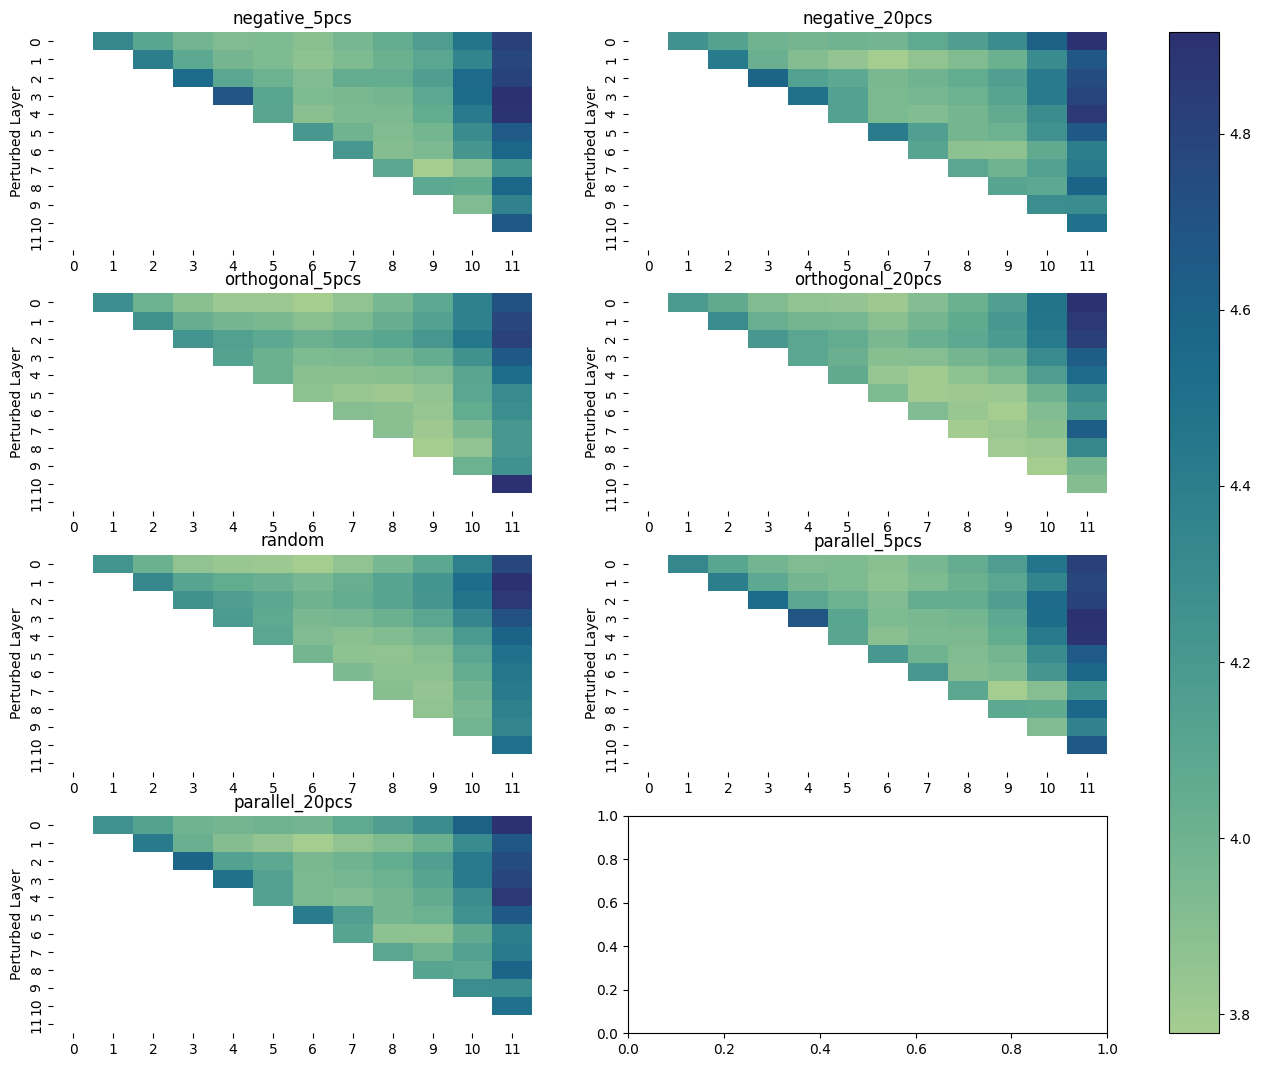

In [47]:
layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

perbs = {"negative_5pcs": negative_5pcs, "negative_20pcs": negative_20pcs, "orthogonal_5pcs": orthogonal_5pcs, "orthogonal_20pcs": orthogonal_20pcs, "random": random, "parallel_5pcs": parallel_5pcs, "parallel_20pcs": parallel_20pcs}
#make a grid to put plots in
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 13))
for ax, (name, df) in zip(axs.flatten(), perbs.items()):
    new_df = pd.DataFrame(columns=[f"distance_{i}" for i in layers])
    for i in layers:
        new_df[f"distance_{i}"] = np.log(df[f"distance_{i}"] / 0.01)
        #change title of column just to be number
        new_df.rename(columns={f"distance_{i}": i}, inplace=True)
    #heatmap of distances
    sns.heatmap(new_df, ax = ax, cmap="crest", cbar=False)
    ax.set_title(name)
    ax.set_ylabel("Perturbed Layer")

fig.colorbar(axs[0, 0].get_children()[0], ax=axs, orientation='vertical', fraction=.1)
plt.show()


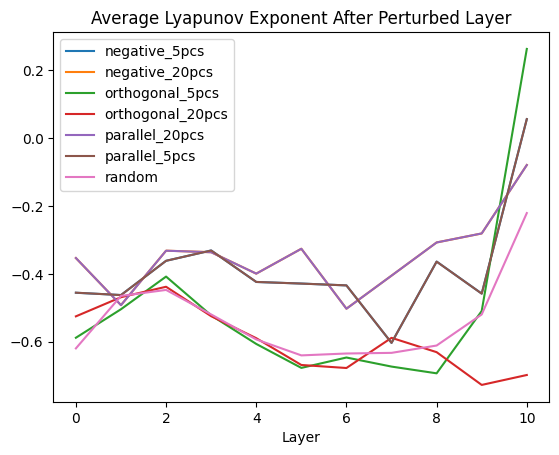

In [46]:
layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
plt.plot(layers, negative_5pcs["distance_lyapunov"], label="negative_5pcs")
plt.plot(layers, negative_20pcs["distance_lyapunov"], label="negative_20pcs")
plt.plot(layers, orthogonal_5pcs["distance_lyapunov"], label="orthogonal_5pcs")
plt.plot(layers, orthogonal_20pcs["distance_lyapunov"], label="orthogonal_20pcs")
plt.plot(layers, parallel_20pcs["distance_lyapunov"], label="parallel_20pcs")
plt.plot(layers, parallel_5pcs["distance_lyapunov"], label="parallel_5pcs")
plt.plot(layers, random["distance_lyapunov"], label="random")
plt.title("Average Lyapunov Exponent After Perturbed Layer")
plt.xlabel("Layer")
plt.legend()
plt.show()


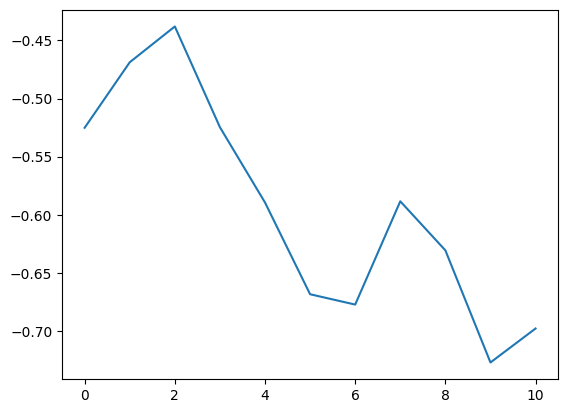

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

orthogonal_20pcs = pd.read_csv("/om2/user/jackking/modular_transformers/modular_transformers/dynamics/orthogonal_20pcs/token_1_results_df.csv", index_col=0)
plt.plot(layers, orthogonal_20pcs["distance_lyapunov"], label="orthogonal_20pcs")


In [60]:
def distance_divergence(act1, act2):
    difference = act1 - act2
    print(difference)
    sum = 0
    for i in range(len(difference)):
        sum = sum + (act1[i] - act2[i])**2
    print(np.sqrt(sum))
    distance = torch.norm(difference, p=2)
    return distance.item(), torch.norm(difference, p=2, dim=1).mean()

act1 = torch.randn((5, 2))
random_perp = torch.randn((5, 2))
perp_size = 0.5
act2 = act1 + (random_perp / torch.norm(random_perp)) * perp_size

distance_divergence(act1, act2)

tensor([[-0.0082,  0.0998],
        [-0.1431, -0.3588],
        [-0.0228,  0.1213],
        [ 0.1960,  0.0860],
        [-0.1723, -0.0048]])
tensor([0.2986, 0.4011])


(0.5, tensor(0.1992))

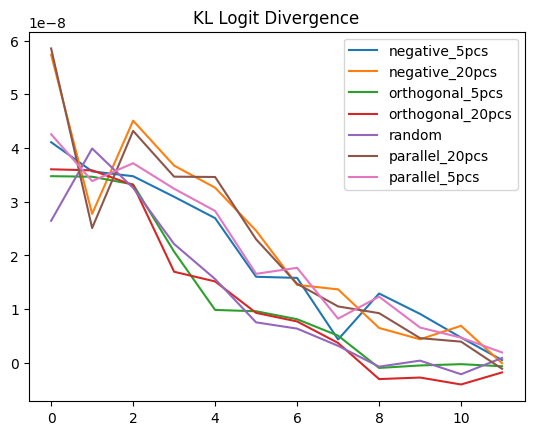

In [48]:
layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
plt.plot(layers, negative_5pcs["KL_logit_div"], label="negative_5pcs")
plt.plot(layers, negative_20pcs["KL_logit_div"], label="negative_20pcs")
plt.plot(layers, orthogonal_5pcs["KL_logit_div"], label="orthogonal_5pcs")
plt.plot(layers, orthogonal_20pcs["KL_logit_div"], label="orthogonal_20pcs")
plt.plot(layers, random["KL_logit_div"], label="random")
plt.plot(layers, parallel_20pcs["KL_logit_div"], label="parallel_20pcs")
plt.plot(layers, parallel_5pcs["KL_logit_div"], label="parallel_5pcs")
plt.title("KL Logit Divergence")
plt.legend()
plt.show()

In [56]:
activations = torch.load(f"/om2/user/jackking/MyData/dynamics/activations/random/1_perturbed_activations.pt")
activations[0][0][0,:]

tensor([ 4.9348e-01, -9.6656e-01, -1.5721e+00, -9.6200e-02,  4.0117e-01,
         7.7038e-01,  4.6862e-01, -2.0559e-01, -3.8084e-01, -4.4492e-01,
         6.1073e-01,  4.8725e-01, -1.2434e+00, -6.7528e-01,  1.6901e+00,
        -4.2080e-01,  2.5824e-02,  1.1260e+00,  6.4773e-01, -9.6434e-01,
         1.8725e-01, -8.5413e-01,  2.6708e-01, -4.5092e-01,  3.1206e-01,
         1.3940e+00,  3.4038e-01,  1.0855e-01,  2.7508e-02, -1.1391e+00,
        -8.4725e-01, -9.9753e-01, -1.2048e-01,  1.0682e+00,  4.1412e-03,
        -4.7930e-01, -3.7748e-01, -2.5346e-01, -3.3728e-03,  3.5013e-01,
         4.8644e-01, -1.0668e-01,  9.9648e-01, -1.4112e-01,  1.3007e+00,
         6.1748e-01, -2.7075e-01, -5.4335e-01, -2.4031e-01,  5.0662e-01,
        -4.0287e-01,  1.7181e-01,  9.9611e-01,  1.2305e+00,  1.3341e-01,
         6.1385e-02,  2.1845e+00, -9.2341e-02,  5.1635e-01,  1.5175e+00,
         1.5165e-01,  5.8274e-02,  1.2484e-01,  5.4157e-01,  3.0328e+00,
         6.3743e-01, -8.2796e-02,  4.1149e-01, -2.3

In [76]:
activations = torch.load(f'/om2/user/jackking/MyData/dynamics/activations/orthogonal_5pcs/1_perturbed_activations.pt')
pcas = get_pcas(activations, 12, 7)

Token 0


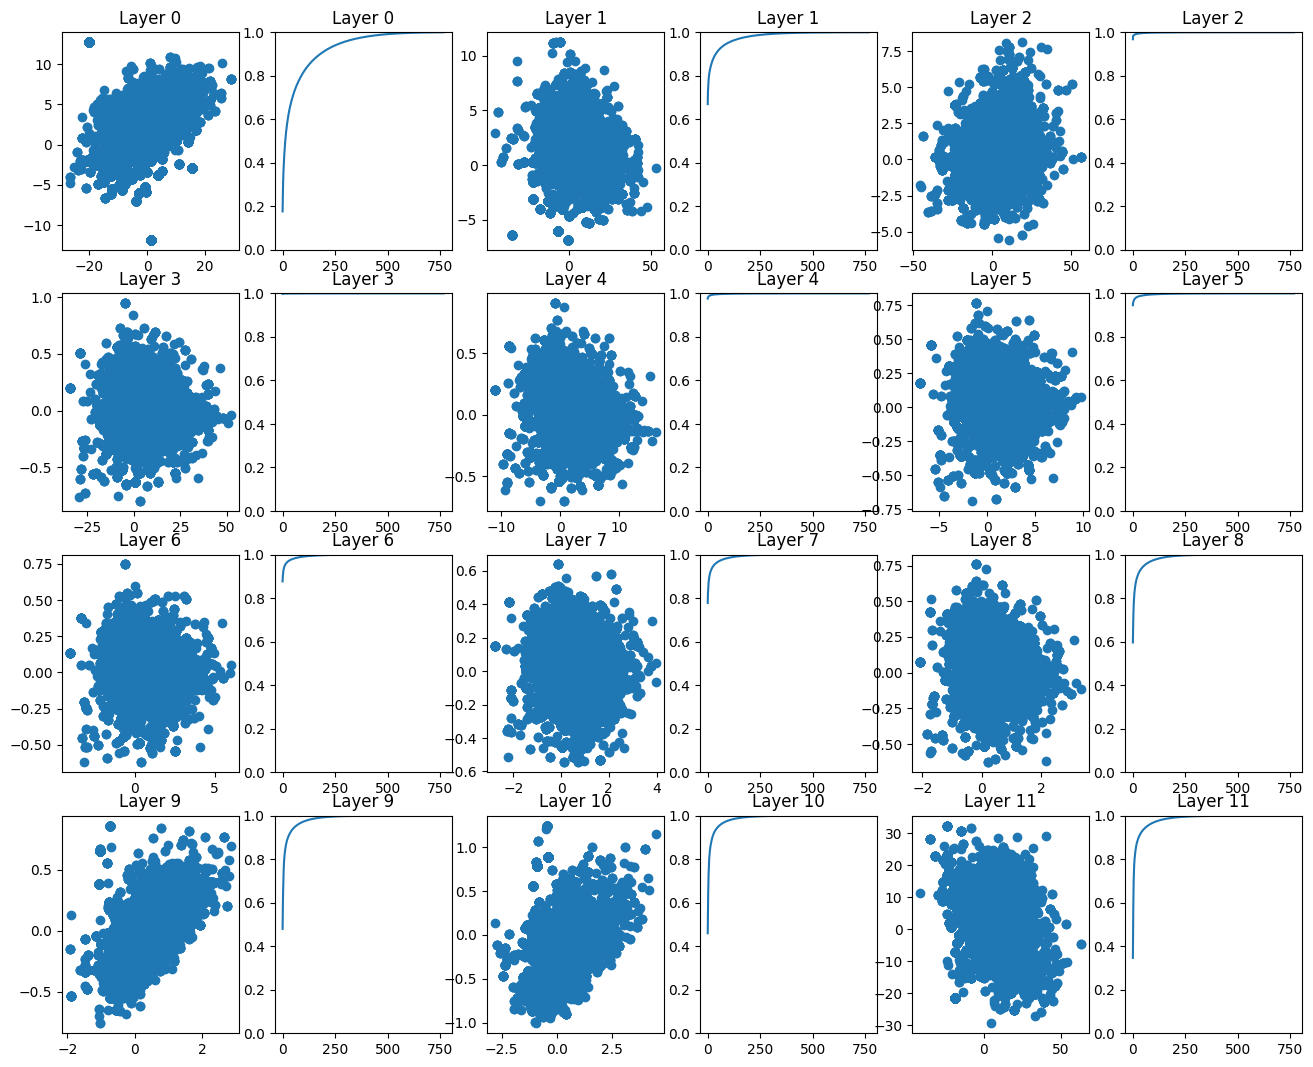

Token 1


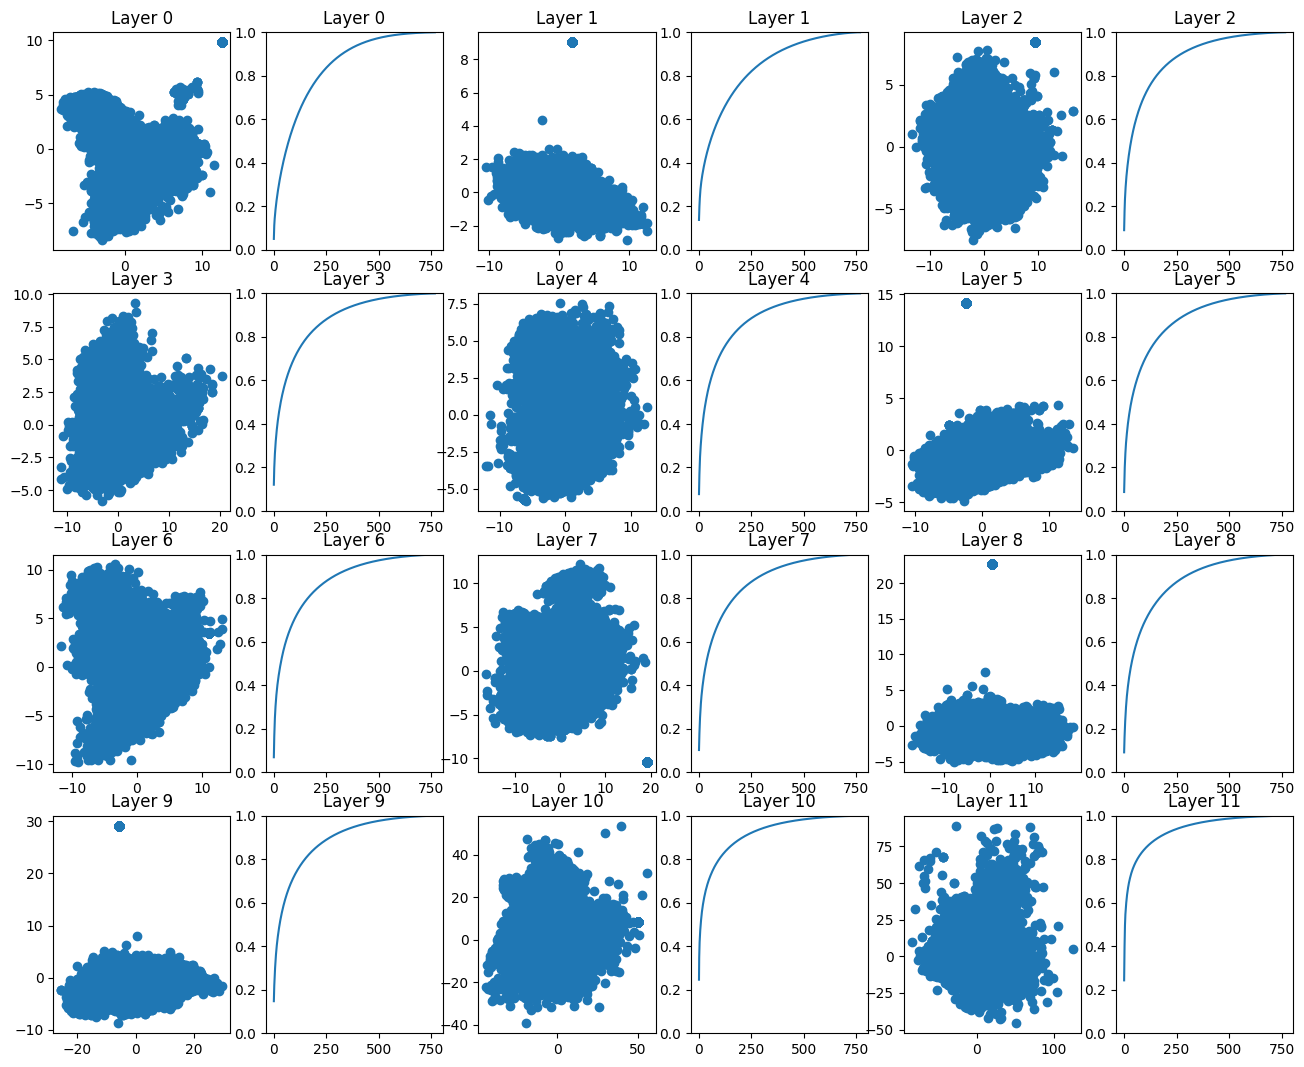

Token 2


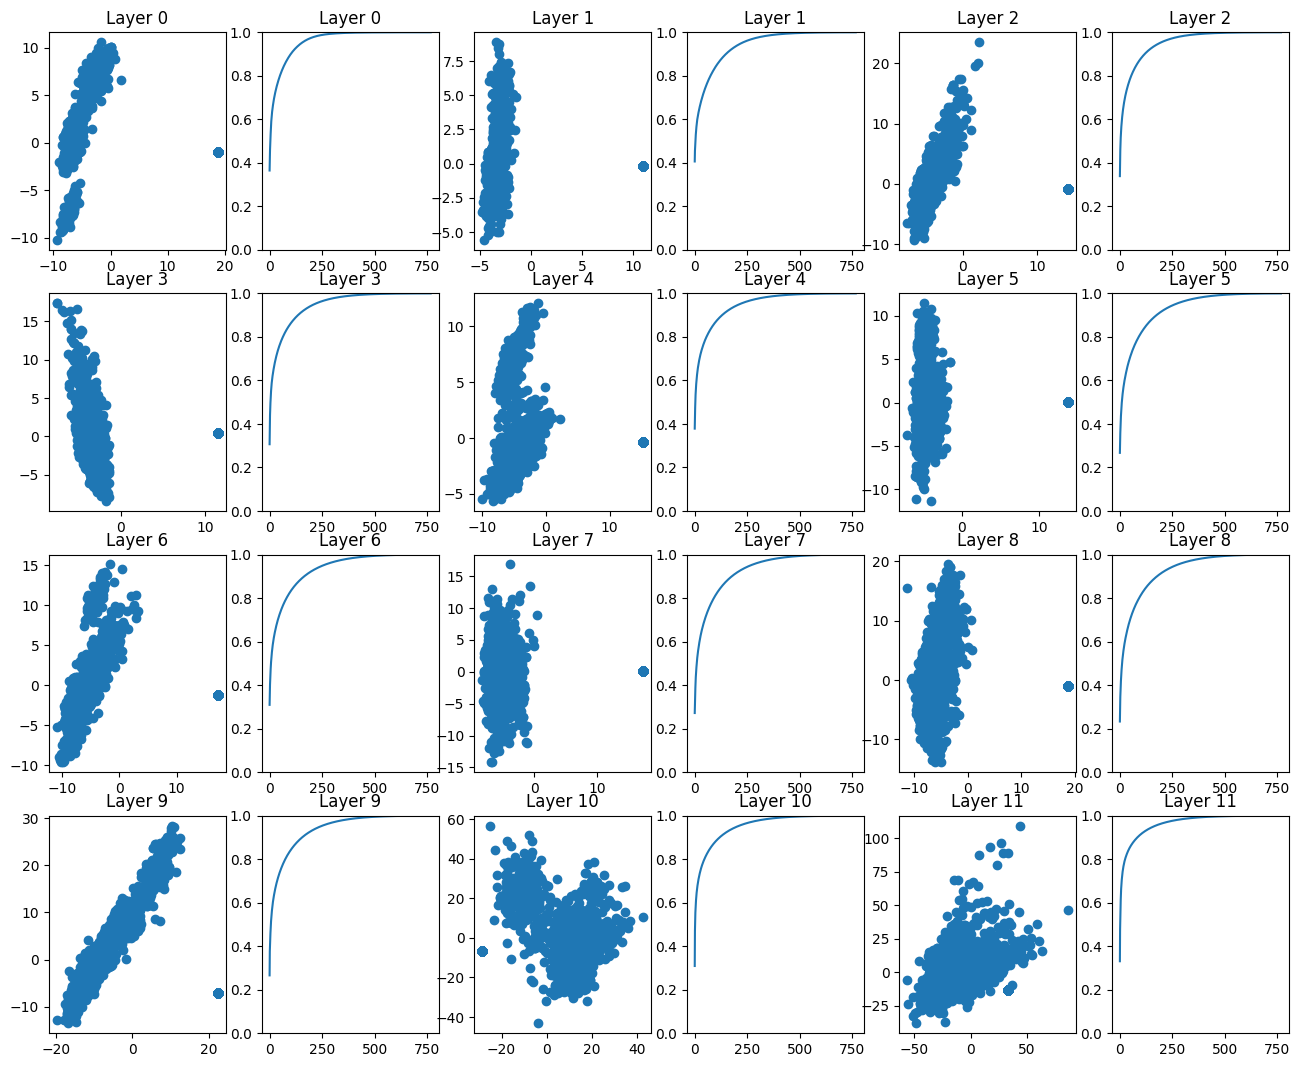

Token 3


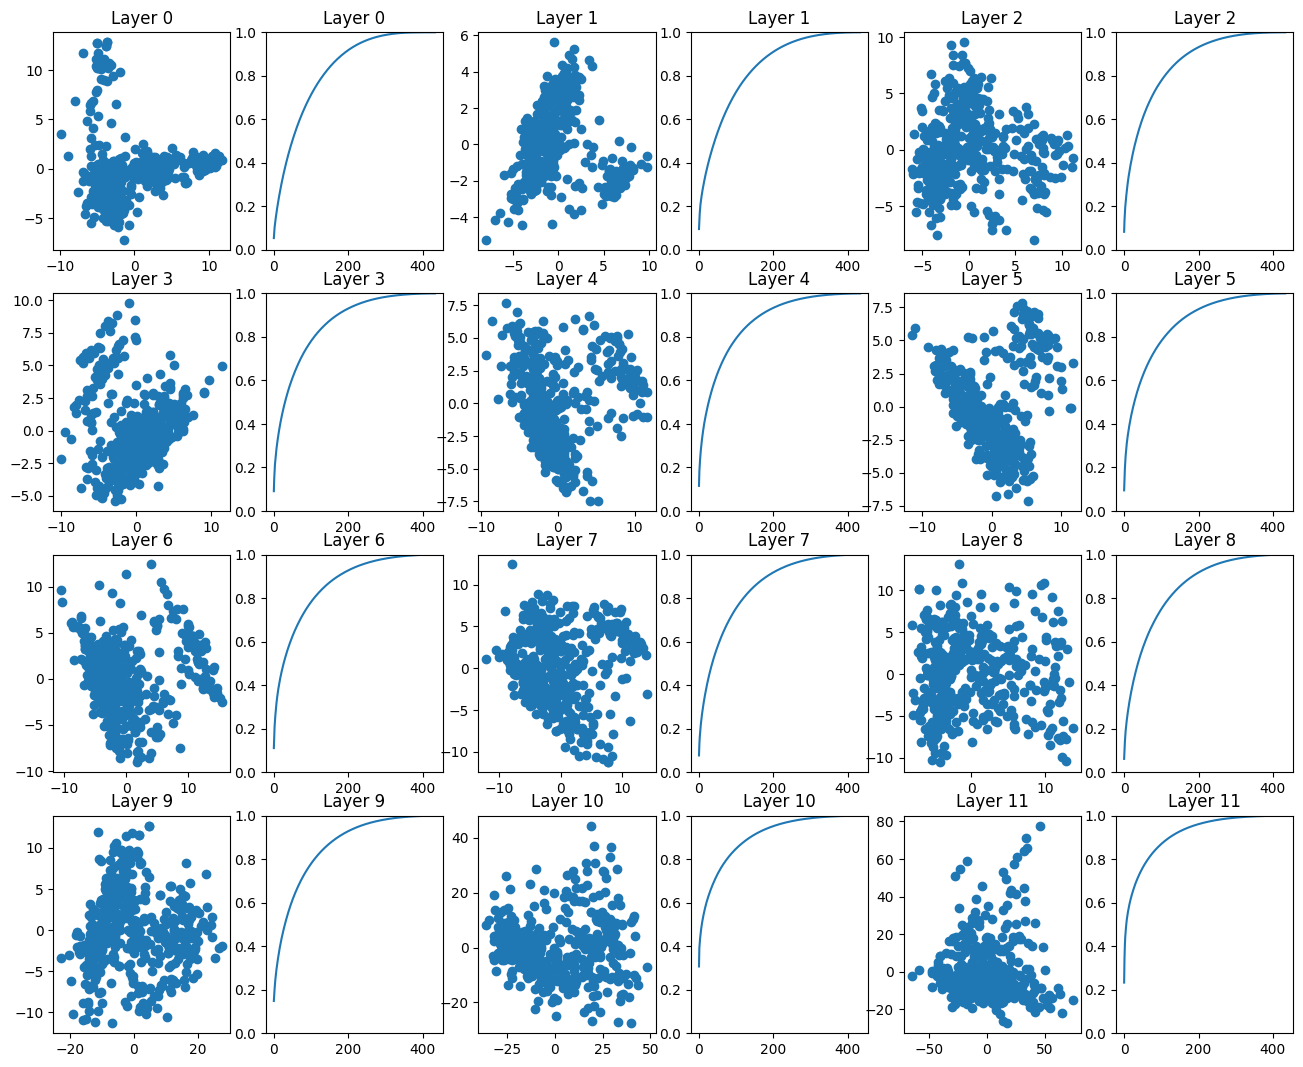

Token 4


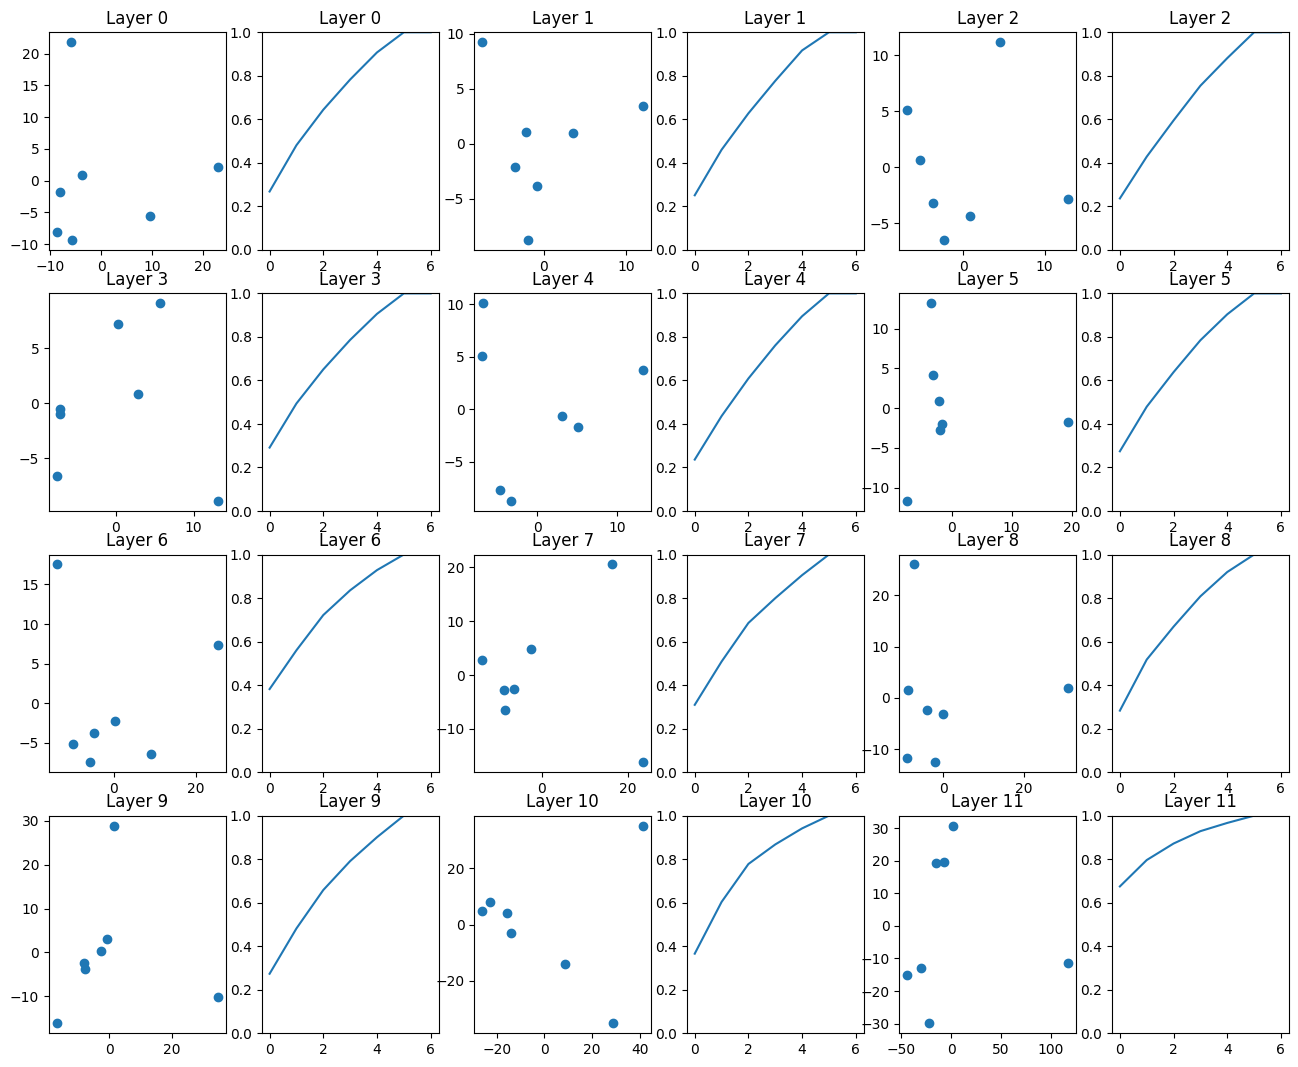

Token 5


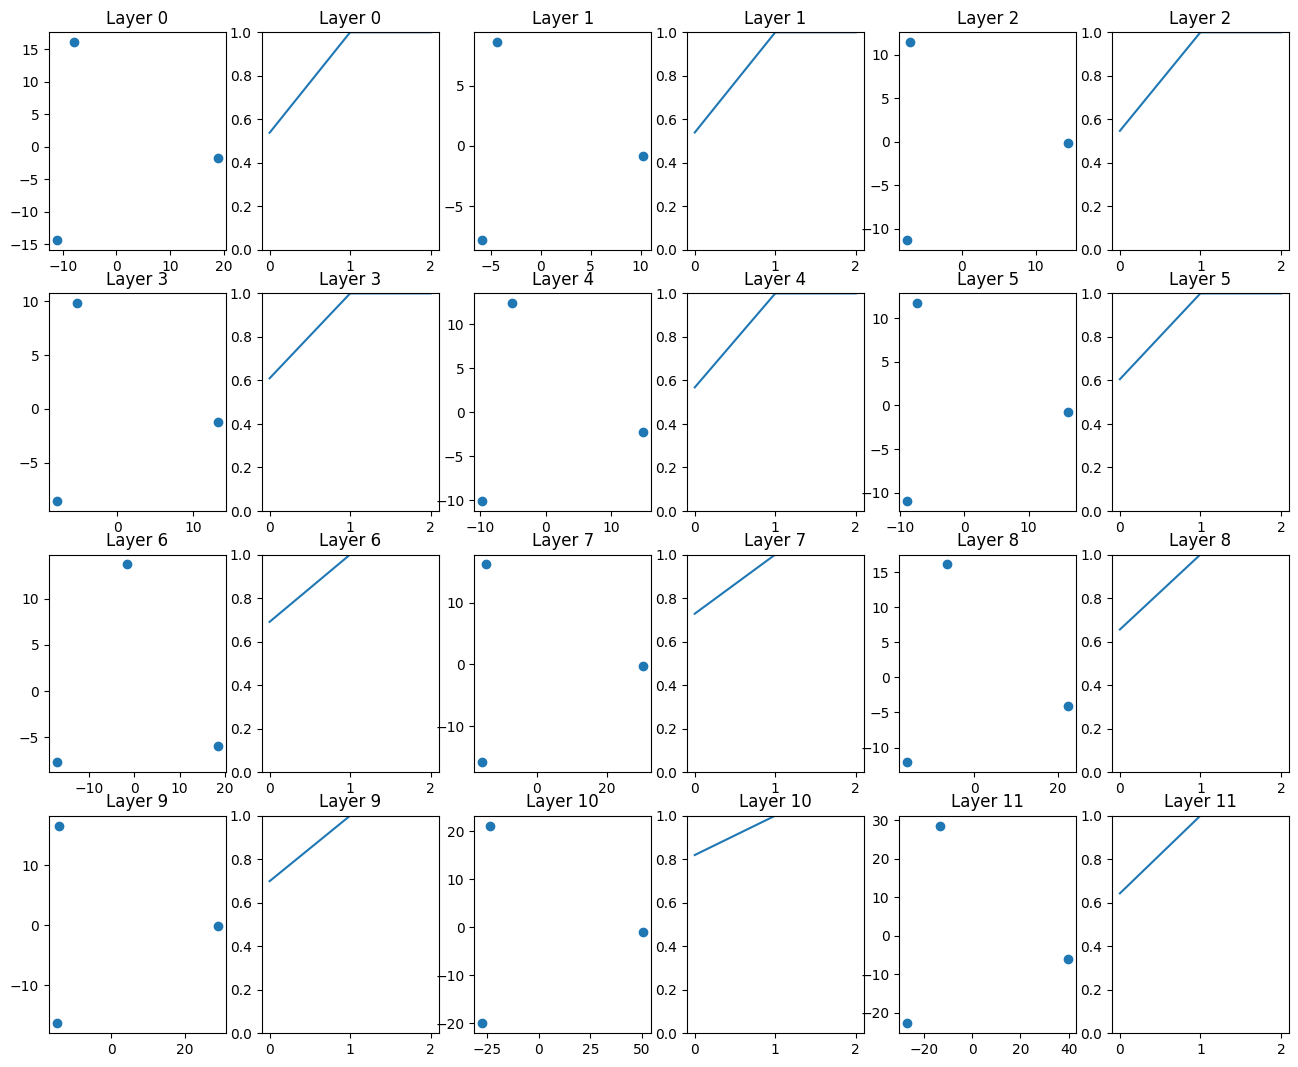

Token 6


AttributeError: 'NoneType' object has no attribute 'transform'

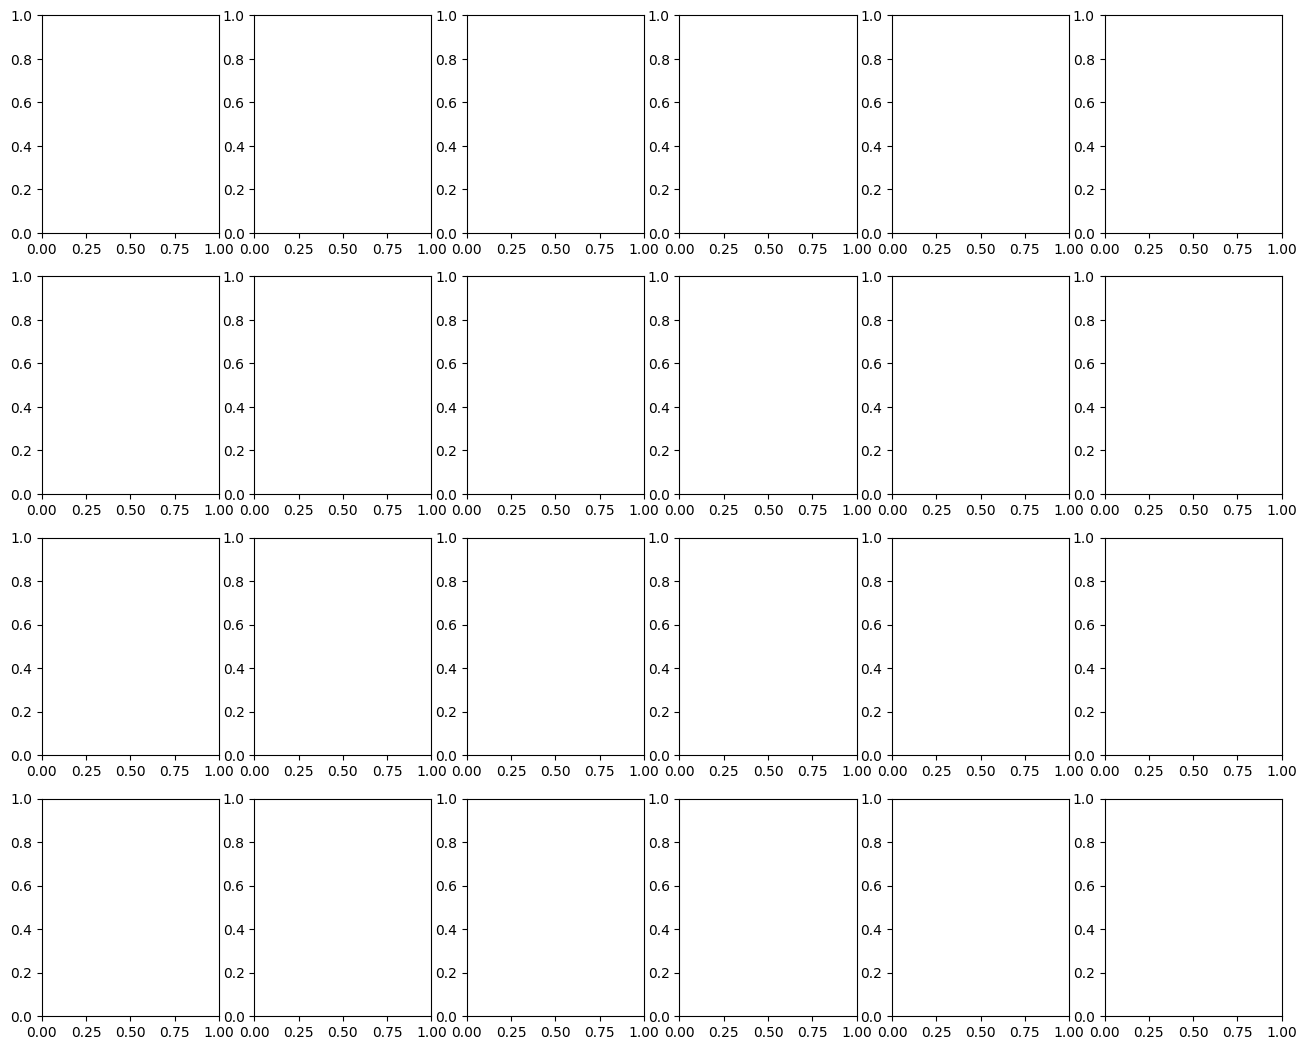

In [81]:
plot_pcas(pcas, activations)

In [71]:
pertubation = "random"
bigrams = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{pertubation}/bigram_results.csv", index_col=0)
bigrams

,bigram,0,1,2,3,4,5,6,7,8,9,10,11
0,bed and,everyone,We,to,all,and,\n,the,st,error,ッド,VILLE,Heaven
1,bread and,to,In,],mand,ers,S,cold,G,ist,testing,TI,ilk
2,salt and,�,the,\n,their,CAM,Sen,as,X,und,results,.................................................,icum
3,thunder and,A,repeated,\n,of,",",",",1,8,Safety,king,hrs,etheless
4,social media,special,\n,and,et,\n,.,",",-,still,waiting,Studies,encies
5,credit card,and,Esc,und,/,custody,to,.,about,Americans,her,Racing,arf
6,climate change,(,yet,v,time,The,",",and,ation,years,or,dom,abor
7,artifical intelligence,add,NFL,pt,",",",",",",(,ettel,and,ate,exit,�
8,global warming,vel,?,Scheme,is,not,",",making,Carlton,"""",-,bite,icable
9,state of,inter,\n,\n,their,/,EL,Ab,more,MS,"""",airport,cial


In [196]:
def softmax(logits):
    """Apply the softmax function to convert logits to probabilities."""
    e_x = np.exp(logits - np.max(logits))
    return e_x / e_x.sum(axis=0)

def entropy_of_logits(logits):
    """Calculate the entropy of a set of logits."""
    probabilities = softmax(logits)
    entropy = -np.sum(probabilities * np.log(probabilities + 1e-9))  # Adding a small constant to avoid log(0)
    return entropy

In [201]:
#find the to 10 most bigrams with the highest or lowest entropy
def get_top_bigrams(model, bigram_tokens, highest=True):
    top_bigrams = []
    for bigram in bigram_tokens:
        input = bigram.to(device)
        output = model(input)
        logits = output.logits[-1, :].detach().cpu().numpy()
        entropy = entropy_of_logits(logits)
        top_bigrams.append((entropy, bigram))
    top_bigrams.sort(key=lambda x: x[0], reverse=highest)
    return top_bigrams

In [203]:
bigrams = get_top_bigrams(orig_model, bigram_tokens)
#convert to text
bigram = [(b[0], tokenizer.decode(b[1].squeeze())) for b in bigrams[-15:]]
for b in bigram:
    print(b[1])

the fact
Click here
a number
as well
would like
all kinds
Sign up
in order
In addition
For example
the use
Terms and
All rights
be able
in accordance


In [50]:
#pick random tokens to sample
token_selection = np.random.choice(range(num_bigrams), 20, replace=False)
sample_outputs([perturbed_model, orig_model], token_selection, bigram_tokens)

area of-> Pilgrim
area of-> the
of you->Offline
of you->,
or more-> Yuk
or more-> than
to any->ront
to any-> other
or in-> Savannah
or in-> the
information is->amel
information is-> not
can be->icative
can be-> used
go to->Twe
go to-> the
If the-> Sk
If the-> user
been a-> affiliate
been a-> big
Number of->ulin
Number of-> the
the entire->bay
the entire-> world
the work->OSS
the work-> of
you need->olson
you need-> to
and how->eless
and how-> to
you have-> resil
you have-> to
is being->=#
is being-> a
was not->assian
was not-> a
will be-> Confederation
will be-> a
<S> of->��
<S> of-> the
